In [77]:
from dotenv import load_dotenv
import pandas as pd
import csv
import os
import base64
import requests
import json
from pprint import pprint
from ids import id
from ids import secret
# ID token for Genius API
from ids import genius_token

#For Genius API

import numpy as np
import lyricsgenius

# Number of repetitions for each words in the bag of words
REPETITION_COUNTS=2

In [3]:
load_dotenv()
client_id = id
client_secret = secret
client_genius = genius_token

# Asegurarse de que los Id's están presentes, porque si no, la función get token da error.

In [5]:
# Definiendo funciones <3

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization" : "Basic " + auth_base64,
        "Content-Type" : "application/x-www-form-urlencoded"
    }

    data = {"grant_type" : "client_credentials"}

    result = requests.post(url, headers = headers, data = data)
    json_response = json.loads(result.content)
    token = json_response["access_token"]
    return token

def get_auth_header(token):
    return{"Authorization" : "Bearer " + token}

def search_for_playlist(token, playlist_name):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    query = f"?q={playlist_name}&type=playlist&limit=1"
    query_url = url + query
    result = requests.get(query_url, headers = headers)
    json_result_playlist = json.loads(result.content)["playlists"]["items"]
    if len(json_result_playlist) == 0:
        print("No playlist with this name found...")
        return None
    
    # pprint(json_result_playlist)
    return json_result_playlist[0]

def get_songs_in_playlist(token, artist_id):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}"
    headers = get_auth_header(token)
    result = requests.get(url, headers = headers)
    json_result = json.loads(result.content)["tracks"]["items"]
    # pprint(json_result)
    return json_result


In [8]:
token = get_token()
result = search_for_playlist(token, "Top Canciones 2019")
playlist_id = result["id"]
songs = get_songs_in_playlist(token, playlist_id)
song_list = []
for idx, song in enumerate(songs):
    # print(f'{idx + 1}. {song["track"]["name"]}')
    song_data = {"Song":song["track"]["name"],
                 "Artist":song["track"]["artists"][0]["name"],
                 "Song Lenght (ms)":song["track"]["duration_ms"],
                 "Popularity":song["track"]["popularity"],
                 "Release date":song["track"]["album"]["release_date"],
                 "Song Id":song["track"]["id"]}
    song_list.append(song_data)
# pprint(song_list)
# pprint(songs)
spoti_19 = pd.DataFrame(song_list)
spoti_19.head(10)

,Song,Artist,Song Lenght (ms),Popularity,Release date,Song Id
0,Calma - Remix,Pedro Capó,238200,77,2018-10-05,5iwz1NiezX7WWjnCgY5TH4
1,Con Calma,Daddy Yankee,193226,83,2019-01-24,5w9c2J52mkdntKOmRLeM2m
2,Te Vi,Piso 21,231848,80,2018-12-14,059bcIhyc2SBwm6sw2AZzd
3,Otro Trago,Sech,225933,75,2019-04-19,1Ej96GIBCTvgH7tNX1r3qr
4,Callaita,Bad Bunny,250533,80,2019-05-31,2TH65lNHgvLxCKXM3apjxI
5,Desconocidos,Mau y Ricky,204453,65,2018-10-12,0s5DNDV6LAKn2u2Ufa3VjQ
6,HP,Maluma,184435,76,2019-05-17,1LIqNVhaIgxXUt2eVoIQJ3
7,Secreto,Anuel AA,258799,79,2019-01-15,5W83ErFkO3aKAIS1WMi6u0
8,LA CANCIÓN,J Balvin,242573,89,2019-06-28,0fea68AdmYNygeTGI4RC18
9,Adan y Eva,Paulo Londra,258638,72,2018-11-05,6FyRXC8tJUh863JCkyWqtk


In [7]:
#Tomar la columna Song Id del DataFrame con los Top Tracks y convertir los valores en una lista de strings separadas por comas, para pasarlo así al request de los Audio Features

id_list = spoti_19["Song Id"]
id_list = ",".join(id_list)
#id_list


# Spotify audio features

In [9]:
#Request para los Audio Features

def get_AF_in_songs(token, id_list):
    url = f"https://api.spotify.com/v1/audio-features?ids={id_list}"
    headers = get_auth_header(token)
    response = requests.get(url, headers = headers)
    response_json = response.json()
    #pprint(response_json)
    return response_json

In [10]:
token = get_token()
audio_features_data = get_AF_in_songs(token, id_list)["audio_features"]
audio_features_list = []


for idx, af in enumerate(audio_features_data):
    audio_features = {"Acousticness":af["acousticness"],
                 "Danceability":af["danceability"],
                 "Energy":af["energy"],
                 "Instrumentalness":af["energy"],
                 "Liveness":af["energy"],
                 "Speechiness":af["speechiness"],
                 "Tempo":af["tempo"],
                 "Valence":af["valence"]}
    audio_features_list.append(audio_features)
audio_features_df = pd.DataFrame(audio_features_list)
#audio_features_df

spoti_19_af_df = pd.concat([spoti_19, audio_features_df], axis = 1)
spoti_19_af_df

,Song,Artist,Song Lenght (ms),Popularity,Release date,Song Id,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Tempo,Valence
0,Calma - Remix,Pedro Capó,238200,77,2018-10-05,5iwz1NiezX7WWjnCgY5TH4,0.3230,0.826,0.773,0.773,0.773,0.0524,126.899,0.761
1,Con Calma,Daddy Yankee,193226,83,2019-01-24,5w9c2J52mkdntKOmRLeM2m,0.1100,0.737,0.860,0.860,0.860,0.0593,93.989,0.656
2,Te Vi,Piso 21,231848,80,2018-12-14,059bcIhyc2SBwm6sw2AZzd,0.0446,0.877,0.777,0.777,0.777,0.1170,102.020,0.706
3,Otro Trago,Sech,225933,75,2019-04-19,1Ej96GIBCTvgH7tNX1r3qr,0.1360,0.746,0.700,0.700,0.700,0.3410,176.044,0.619
4,Callaita,Bad Bunny,250533,80,2019-05-31,2TH65lNHgvLxCKXM3apjxI,0.6000,0.610,0.624,0.624,0.624,0.3090,176.169,0.244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Sucker,Jonas Brothers,181026,84,2019-06-07,22vgEDb5hykfaTwLuskFGD,0.0427,0.842,0.734,0.734,0.734,0.0588,137.958,0.952
96,Cuando Nadie Ve,Morat,219586,81,2018-10-25,71iAechwVKGu26pahzFL0k,0.1330,0.806,0.778,0.778,0.778,0.0616,95.993,0.840
97,Que Le De,Rauw Alejandro,225600,60,2019-01-25,08aYFNUTIOMGq93e2VSArQ,0.1900,0.770,0.750,0.750,0.750,0.0785,99.997,0.609
98,Ponle,Rvssian,164764,67,2018-09-06,28O1p0bQXH2F6Qn8jBZZR4,0.1880,0.857,0.772,0.772,0.772,0.1950,94.030,0.589


# Genius Lyrics API

In [12]:
LyricsGenius = lyricsgenius.Genius(client_genius)

lyrics_df = spoti_19_af_df.Song
lyrics_df = pd.DataFrame(lyrics_df)
lyrics_df.head(10)

,Song
0,Calma - Remix
1,Con Calma
2,Te Vi
3,Otro Trago
4,Callaita
5,Desconocidos
6,HP
7,Secreto
8,LA CANCIÓN
9,Adan y Eva


In [13]:
# The package got some timeout issue so these two lines are needed. If you don't then there will be error when you scrape
# Source: https://github.com/johnwmillr/LyricsGenius/issues/121

LyricsGenius.timeout = 15  #timeout
LyricsGenius.sleep = 5

In [14]:
#Quick test first song

sample_song = lyrics_df.Song[0]
print(f"Name of the first song in the database is: {sample_song}")

# Search for the song's lyric
searched_song = LyricsGenius.search_song(sample_song)
print(f"The lyric is:\n{searched_song.lyrics}")

Name of the first song in the database is: Calma - Remix
Searching for "Calma - Remix"...
Done.
The lyric is:
24 ContributorsCalma (Remix) Lyrics[Letra de "Calma (Remix)"]

[Intro: Pedro Capó & Farruko]
Laramercy gang
Welcome to the paradise
¡Farru!
Cuatro abrazos y un café
Apenas me desperté
Y al mirarte recordé
Que ya todo lo encontré
Tu mano en mi mano
De todo escapamos
Juntos ver el sol caer
(Let them enjoy the paradise)

[Coro: Pedro Capó]
Vamos pa' la playa, pa’ curarte el alma
Cierra la pantalla, abre la Medalla
Todo el mar Caribe, viendo tu cintura
Tú le coqueteas, tú eres busca bullas y me gusta

[Post-Coro: Pedro Capó]
Lento y contento, cara al vie-ento
Lento y contento, cara al vie-ento

[Verso 1: Farruko]
Ya, ya, ya, ¡Farru!
Y aprovecha que el sol 'tá caliente y vamo' a disfrutar el ambiente
Vámono’ a meternos pa'l agua pa' que veas qué rico se siente
Y vámono' en tropical, por to'a la costa a chinchorrear
De chinchorro a chinchorro paramo' a darno' una Medalla
Bien fría, p

In [15]:
# Create an array to store each song's lyric
lyrics_arr = []

# Traverse through the database, get the song's lyrics from title, and do some preprocessing
for i in range(len(lyrics_df)):
    # get title
    song_title = lyrics_df.Song[i]
    
    # search for song in genius.com
    searched_song = LyricsGenius.search_song(song_title)
    
    # if we can't find a song's lyrics then skip and append empty string
    if searched_song is None:
        lyrics_arr.append("")
        continue
        
    # get the lyric
    lyric = searched_song.lyrics
    
    # replace the lyrics newline with ". "
    lyric = lyric.replace("\n", ". ")
    
    # remove initial non-lyrics character:
    # Source: https://thispointer.com/remove-string-before-a-specific-character-in-python/
    # lyric = lyric[lyric.index('.') + 1 :]
    
    # append the processed lyric to the array
    lyrics_arr.append(lyric)

Searching for "Calma - Remix"...
Done.
Searching for "Con Calma"...
Done.
Searching for "Te Vi"...
Done.
Searching for "Otro Trago"...
Done.
Searching for "Callaita"...
Done.
Searching for "Desconocidos"...
Done.
Searching for "HP"...
Done.
Searching for "Secreto"...
Done.
Searching for "LA CANCIÓN"...
Done.
Searching for "Adan y Eva"...
Done.
Searching for "11 PM"...
Done.
Searching for "Soltera (Remix)"...
Done.
Searching for "Con Altura"...
Done.
Searching for "Tal Vez"...
Done.
Searching for "China"...
Done.
Searching for "No Me Conoce - Remix"...
Done.
Searching for "Pa Mí - Remix"...
Done.
Searching for "Ella Quiere Beber - Remix"...
Done.
Searching for "Un Año"...
Done.
Searching for "MIA"...
Done.
Searching for "Dancin (feat. Luvli) - Krono Remix"...
Done.
Searching for "Sunflower - Spider-Man: Into the Spider-Verse"...
Done.
Searching for "7 rings"...
Done.
Searching for "Señorita"...
Done.
Searching for "bad guy"...
Done.
Searching for "Baby Girl (feat. Lalo Ebratt)"...
Done.

In [17]:
# Check length number of songs
len(lyrics_arr)

100

In [19]:
# Append lyric columns
lyrics_df['lyrics'] = lyrics_arr

# Replace "" with Nan
lyrics_df = lyrics_df.replace('', np.nan)

# Drop Nan
lyrics_df = lyrics_df.dropna(subset = ["lyrics"])
lyrics_df

,Song,lyrics
0,Calma - Remix,"24 ContributorsCalma (Remix) Lyrics[Letra de ""..."
1,Con Calma,31 ContributorsTranslationsEnglishCon Calma Ly...
2,Te Vi,"30 ContributorsToda (Remix) Lyrics[Letra de ""T..."
3,Otro Trago,"11 ContributorsOtro Trago Lyrics[Letra de ""Otr..."
4,Callaita,44 ContributorsTranslationsEnglishDeutschItali...
...,...,...
95,Sucker,166 ContributorsTranslationsDeutschไทย / Phasa...
96,Cuando Nadie Ve,11 ContributorsCuando Nadie Ve Lyrics[Letra de...
97,Que Le De,77 ContributorsTranslationsDeutschGasolina Lyr...
98,Ponle,"7 ContributorsPonle Lyrics[Letra de ""Ponle""]. ..."


# Bag of words

In [22]:
# Create a bag-of-words column
lyrics_df['bag'] = lyrics_df.lyrics.map(lambda t: t.replace('!','').replace('.','').lower().split())
lyrics_df.head()

,Song,lyrics,bag
0,Calma - Remix,"24 ContributorsCalma (Remix) Lyrics[Letra de ""...","[24, contributorscalma, (remix), lyrics[letra,..."
1,Con Calma,31 ContributorsTranslationsEnglishCon Calma Ly...,"[31, contributorstranslationsenglishcon, calma..."
2,Te Vi,"30 ContributorsToda (Remix) Lyrics[Letra de ""T...","[30, contributorstoda, (remix), lyrics[letra, ..."
3,Otro Trago,"11 ContributorsOtro Trago Lyrics[Letra de ""Otr...","[11, contributorsotro, trago, lyrics[letra, de..."
4,Callaita,44 ContributorsTranslationsEnglishDeutschItali...,"[44, contributorstranslationsenglishdeutschita..."


In [23]:
# Create a number of words in each bag of words
lyrics_df['len'] = lyrics_df.bag.map(len)
lyrics_df.head()

,Song,lyrics,bag,len
0,Calma - Remix,"24 ContributorsCalma (Remix) Lyrics[Letra de ""...","[24, contributorscalma, (remix), lyrics[letra,...",478
1,Con Calma,31 ContributorsTranslationsEnglishCon Calma Ly...,"[31, contributorstranslationsenglishcon, calma...",628
2,Te Vi,"30 ContributorsToda (Remix) Lyrics[Letra de ""T...","[30, contributorstoda, (remix), lyrics[letra, ...",945
3,Otro Trago,"11 ContributorsOtro Trago Lyrics[Letra de ""Otr...","[11, contributorsotro, trago, lyrics[letra, de...",649
4,Callaita,44 ContributorsTranslationsEnglishDeutschItali...,"[44, contributorstranslationsenglishdeutschita...",503


In [25]:
# Create a group of bag of words in case we happen to have 2 similar titles
g = lyrics_df.groupby('Song')
g.size()

Song
11 PM                1
7 rings              1
A Través del Vaso    1
Adan y Eva           1
Adictiva             1
                    ..
Verte Ir             1
Ya No Tiene Novio    1
Yo x Ti, Tu x Mi     1
bad guy              1
thank u, next        1
Length: 100, dtype: int64

In [39]:
title_bags = g.bag.aggregate(lambda bag: [w for b in bag.values for w in b])
title_bags
#title_bags[[1]].values

Song
11 PM                [8, contributors11, pm, lyrics[letra, de, "11,...
7 rings              [473, contributorstranslationstürkçeespañolrom...
A Través del Vaso    [6, contributorsa, través, del, vaso, lyrics[l...
Adan y Eva           [18, contributorsadán, y, eva, lyrics[letra, d...
Adictiva             [17, contributorsadictiva, lyrics[letra, de, "...
                                           ...                        
Verte Ir             [17, contributorsverte, ir, lyrics[letra, de, ...
Ya No Tiene Novio    [15, contributorsya, no, tiene, novio, lyrics[...
Yo x Ti, Tu x Mi     [48, contributorstranslationsportuguêsespañoly...
bad guy              [339, contributorstranslationshrvatskitürkçesv...
thank u, next        [398, contributorstranslationstürkçesvenskaesp...
Name: bag, Length: 100, dtype: object

In [40]:
# Compute Term Frequency Matrix
TF_o = title_bags.apply(lambda bag: pd.Series(bag).value_counts())
#trasponer
TF = TF_o.T
#Drop pronombres
TF=TF.drop(["sus","tu","esta","ti","eso"],axis=0)
#Reduccion de posesivos
TF=TF.drop(["su","mí","tus","tu'","mis"],axis=0)
#drop expresiones
TF=TF.drop(["(¡eh)","(¡shu)","(¡jajá)","ey)","(tss,","eh","(ey)","(yeh-eh)","yeh-eh-eh","(woh-oh;","oh","oh;","¡shiuf","o-o-ovy","(yeh-eh-eh)9embed","(mmm,","[estribillo:"],axis=0)
#drop artículos
TF=TF.drop(["los"],axis=0)
#drop nonjunciones
TF=TF.drop(["y","ni"],axis=0)
#errores
TF=TF.drop(["(eh-eh)","uah,","na'","oah,","oah","uah","si","eh,","ah,","[intro]","e’","la’","like[verso","(-la,","-la)","lo'","yeh-eh-eh)","(yeh-eh-eh)","18","ah…","(ah)","[interludio]","[puente]","[estribillo]","(¡wuh)","ah","oh,","¿la","[verso","la'","(woh)","[pre-estribillo]","esto'","(no)","-la,","(woh-oh,","e'","do'","yeh-eh)","ey","(yeh)","se","es","6","¿a","(eh,","11","e","yep)469embed","contributorstranslationstürkçeespañolromânăportuguêspolskiitalianohebrewελληνικάdeutschfrançaisnederlandsdanskفارسی7","473","(oh,","yeh)","yeh,","(yeh,","está","no-no)","eh)","ba-ba-baby4embed","(uh)","(uh-ah)","[verso]","contributors11","(eh-eh,","lyrics[letra","yeah","8","(no-no)","no-oh)","[outro]","ba-ba-ba-,","me","lo","(no-no,","e","no,","[pre-coro]","[coro]","una","él)","(pa'","(no","oh-oh-oh","pa'","¿cómo","¿que","él","el","de","a","en","la","tú","que","te","no","un", "o", "u", "pero", "aunque","contributorstranslationstürkçesvenskaespañolрусскийportuguêspolski한국어deutschfrançaisnederlands​thank","so","yee512embed","in","at","on","tú"],axis=0)

TF

Song,11 PM,7 rings,A Través del Vaso,Adan y Eva,Adictiva,Adiós Amor,Aerolínea Carrillo,Ahora Te Puedes Marchar,Amanece,Amigos Con Derechos,...,Te Vi,Tra Tra Tra Remix - Remix,Tutu,Un Año,Vaina Loca,Verte Ir,Ya No Tiene Novio,"Yo x Ti, Tu x Mi",bad guy,"thank u, next"
mejor?,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ves,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
por,9.0,NaN,3.0,NaN,1.0,NaN,2.0,4.0,NaN,NaN,...,8.0,1.0,1.0,3.0,9.0,6.0,1.0,79.0,NaN,NaN
seas,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merece,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
havin',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
met,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
worried,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
"so,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [41]:
#Get all the column names (each word)
low=TF_o.columns.values.tolist()
print(type(low))


<class 'list'>


In [43]:
#DATAFRAME OUT OF LIST OF WORDS
low_df=pd.DataFrame(data=low,columns=['Words'])
low_df

,Words
0,que
1,te
2,no
3,tú
4,mejor?
...,...
8991,contributorstranslationstürkçesvenskaespañolру...
8992,worried
8993,"so,"
8994,"now,"


In [45]:
#remove all the non alphabetical chats
low_df['Words']=low_df['Words'].str.replace(r'\W',"")
low_df

/var/folders/hj/mnl5qf615nbg_vjc6gbrgclc0000gn/T/ipykernel_93058/450727142.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  low_df['Words']=low_df['Words'].str.replace(r'\W',"")


,Words
0,que
1,te
2,no
3,tú
4,mejor
...,...
8991,contributorstranslationstürkçesvenskaespañolру...
8992,worried
8993,so
8994,now


In [46]:
#Getting how many times words are repeated trough the series
freq=low_df.groupby('Words').size()
#words=low_df["Words"].unique()

#getting dataframe
wf_df=pd.DataFrame({"Frequency":freq})
wf_df


,Frequency
Words,
,9
0000,1
011119,1
042,1
051019,1
...,...
último,2
única,2
único,1


In [76]:
#CSV FREQUENCY
gecsv=freq.to_frame()
gecsv.to_csv("FREQUENCY88.csv")

In [79]:
#clean dataframe with counts above REPETITION_COUNTS=2, defined at the beginning of code
df3=wf_df.loc[wf_df["Frequency"]>REPETITION_COUNTS]
df3.to_csv("clean_freq.csv")
df_clean=df3
#---------------------------------------------cleaning data---------------------------------------------------
#Drop numbers
df_clean=df_clean.drop(["1","2","3","5"],axis=0)
#Drop
df_clean=df_clean.drop(["","eheh","eh","yehyehyehyeh","yeheh","yeh","yeah","yah","wuh","wooh","woo","wohoh","woh","uohoh","un","uhuh","uh","uahuah","uah","tra","toa","to","sup","so","pues","prr","porque","a","aa","ahah","ah","ante","ay","b","e","ey","hey","hmm","huh","jaja","jeje","nah","nono","oh","ohoh","ohohoh","ooh","pa","pal",],axis=0)
#drop adverbio
df_clean=df_clean.drop(["ahí","así"],axis=0)
#preposiciones
df_clean=df_clean.drop(["de","for","para","por"],axis=0)
#pronombres
df_clean=df_clean.drop(["él","ella","eso","esto","está","estás","g","it"],axis=0)
#pronombres
df_clean=df_clean.drop(["yo","la","lo","los","me","mi","mí","te","ti"],axis=0)
#conjunciones
df_clean=df_clean.drop(["o","que","qué","y"],axis=0)
df_clean.to_csv("FINAL.csv")
df_clean


,Frequency
Words,
4,3
adiós,3
aguilar,3
ahora,5
alejandro,3
...,...
yehyehyeh,3
yes,3
you,7


In [59]:
#sort highest to lowest
df_clean_sorted=df_clean.sort_values("Frequency",ascending=False)
df_clean_sorted

,Frequency
Words,
no,16
baby,12
fue,10
sube,8
bebé,8
...,...
ill,2
illuminati,2
importa,2


In [60]:
TOP_20_WORDS=df_clean_sorted.iloc[:20,:]
TOP_20_WORDS

,Frequency
Words,
no,16
baby,12
fue,10
sube,8
bebé,8
más,8
remix,8
tú,8
you,7


Text(0, 0.5, 'Frequency')

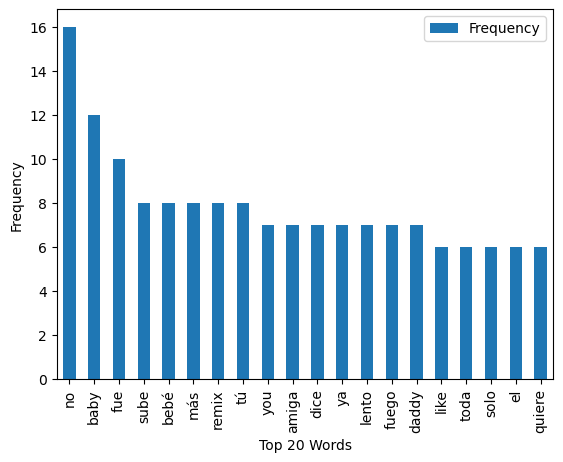

In [61]:
import matplotlib.pyplot as plt
import scipy.stats as st
words_bar_chart = TOP_20_WORDS.plot.bar()
plt.xlabel("Top 20 Words")
plt.ylabel("Frequency")

## Words in Songs Statistics

In [67]:
title_bags
#getting dataframe
words_counts=pd.DataFrame({"Lyrics":title_bags})
#Converting Lyric column to string
words_counts['Lyrics'] = words_counts['Lyrics'].astype(str)
#creating empty column
words_counts["Number of Words"]=""
#counting number of words separated by ","
words_counts["Number of Words"]=words_counts["Lyrics"].apply(lambda n: len(n.split(',')))
words_counts

,Lyrics,Number of Words
Song,,
11 PM,"['8', 'contributors11', 'pm', 'lyrics[letra', ...",444
7 rings,"['473', 'contributorstranslationstürkçeespañol...",574
A Través del Vaso,"['6', 'contributorsa', 'través', 'del', 'vaso'...",202
Adan y Eva,"['18', 'contributorsadán', 'y', 'eva', 'lyrics...",599
Adictiva,"['17', 'contributorsadictiva', 'lyrics[letra',...",541
...,...,...
Verte Ir,"['17', 'contributorsverte', 'ir', 'lyrics[letr...",983
Ya No Tiene Novio,"['15', 'contributorsya', 'no', 'tiene', 'novio...",734
"Yo x Ti, Tu x Mi","['48', 'contributorstranslationsportuguêsespañ...",768


In [73]:
print(type(words_counts))
#words_counts.values

<class 'pandas.core.frame.DataFrame'>


In [80]:
mean_words=words_counts["Number of Words"].mean()
median_words=words_counts["Number of Words"].median()
mode_words=words_counts["Number of Words"].mode()
#VARIANCE
variance_words = words_counts["Number of Words"].var()
#STANDAR DEVIATION
std_words= words_counts["Number of Words"].std()
print(f"Mean={mean_words},Median={median_words},Mode={mode_words},Variance={variance_words},STD={std_words}")

Mean=517.4,Median=479.5,Mode=0    444
Name: Number of Words, dtype: int64,Variance=56749.919191919194,STD=238.22241538511693


In [269]:
#Getting dataframe
mt_df=pd.DataFrame({"Mean":mean_words,"Mode":mode_words,"Median":median_words,"Variance":variance_words,"STD":std_words})
mt_df

,Mean,Mode,Median,Variance,STD
0,517.4,444,479.5,56749.919192,238.222415


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


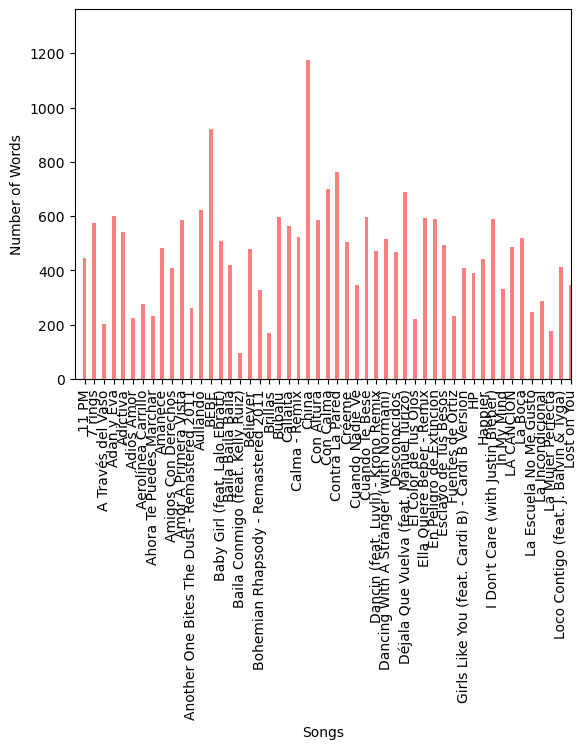

In [118]:
len_words= len(words_counts.index)
x_axis = np.arange(0, len_words)

# List
tick_locations = []
for x in x_axis:
    tick_locations.append(x)
print(tick_locations)

# Finish the plot
plt.bar(x_axis,words_counts["Number of Words"],facecolor="r", alpha=0.5,width = 0.4)

#To specify the xvalues, (x locations, labels)
plt.xticks(tick_locations,words_counts.index,rotation="vertical")
plt.xlim(-1, len_words-50)

#no_words_chart = words_counts.plot.bar()
plt.xlabel("Songs")
plt.ylabel("Number of Words")
plt.show()

Text(0, 0.5, 'Number of Words')

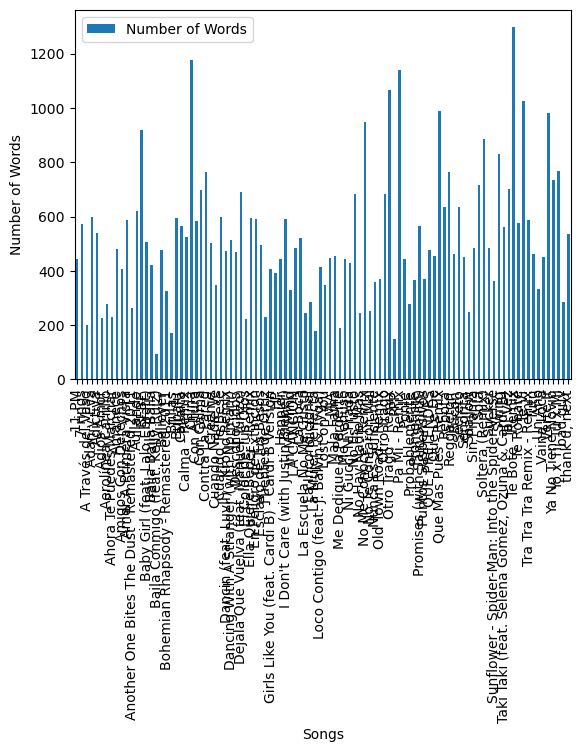

In [92]:
no_words_chart = words_counts.plot.bar()
plt.xlabel("Songs")
plt.ylabel("Number of Words")

In [93]:
#plt.bar(words_counts.index, words_counts["Number of words"], width = 1)